# Appendix E: Estimating Rs and Cm
**Appendix NOT SURE WHERE TO PUT THIS**

During a patch clamp experiment, estimates of $R_s$ and $C_m$ must be made to facilitate slow capacitance and series resistance compensation.
Here we review two methods: A "one-shot" method, that uses current measured during a test pulse without $R_s$ or $C_m$ compensation to make a single prediction, and an "iterative" method, that uses currents measured during successive test pulses while $R_s$ and $C_m$ compensations are refined.

## One-shot approach

In this approach, we follow the pCLAMP 10 User Guide, as available from [Molecular devices](https://support.moleculardevices.com/s/article/pCLAMP-Software-Manual-Download-Page) (the section is absent from the v11 manual).
The relevant section starts on page 199.

We start with a simplified model of the cell.

<img src="resources/rscm-1-circuit.png" style="margin:auto" />

The command potential (no $V_p$ or delays etc) is applied to the series resistance $R_s$, causing a voltage drop to $V_m$.
The cell is represented by its capacitance $C_m$ and a membrane resistance $R_m$.
No leak or offsets are included.

The current through $R_s$ is given by

\begin{align}
I = \frac{V_c - V_m}{R_s} = \frac{V_m}{R_m} + C_m \dot{V}_m
\end{align}

If we take $\dot{V}_c$ to be zero, we can write
\begin{align}
R_s \dot{I} &= -\dot{V}_m \\
C_m R_s \dot{I} &= -C_m \dot{V}_m 
                 = \frac{V_m}{R_m} - I 
                 = \frac{V_c - I R_s}{R_m} - I
                 = \frac{V_c}{R_m} - \frac{I R_s}{R_m} - I
\end{align}
for
\begin{align}
\dot{I} &= \frac{\frac{V_c}{R_m} - \frac{I R_s}{R_m} - I}{C_m R_s}
         = \frac{V_c - I R_s - I R_m}{C_m R_s R_m}
         = \frac{\frac{V_c}{R_s + R_m} - I}{C_m \frac{R_s R_m}{R_s + R_m}}
         = \frac{I_\infty - I}{\tau}        
\end{align}

<img src="resources/rscm-2-protocol.png" style="margin:auto" />

In [2]:
import myokit
import numpy as np

In [14]:
m = myokit.parse_model('''
[[model]]
step.I = 0

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[step]
Rs = 5e-3 [GOhm] in [GOhm]
Rm = 0.5 [GOhm] in [GOhm]
Cm = 40 [pF] in [pF]
Vc = 1 [mV] * engine.pace
    in [mV]
dot(I) = (inf - I) / tau
    in [pA]
    inf = Vc / (Rs + Rm)
        in [pA]
    tau = Cm * Rs * Rm / (Rs + Rm)
        in [ms]
''')
m.check_units(myokit.UNIT_STRICT)

In [32]:
m = myokit.parse_model('''
[[model]]
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
Rs = 15e-3 [GOhm] in [GOhm]
Rm = 0.5 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cp = 5 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]
tau_est = 1e-8 [ms]
    in [ms]
I = Vm / Rm
    in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp - Vm) / Rs + Cf * dot(Vo)) / (Cp + Cf)
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp
    in [mV]
dot(Ve) = (Vc - Ve) / tau_est
    in [mV]
dot(Vr) = (Vc - Vr) / tau_sum
    in [mV]
I_obs = (Vo - Vr) / Rf
    in [pA]
''')
m.check_units(myokit.UNIT_STRICT)

In [33]:
p = myokit.Protocol()
p.schedule(start=0, level=-60, duration=10, period=20)
p.schedule(start=10, level=-70, duration=10, period=20)

In [34]:
s = myokit.Simulation(m, p)
s.pre(200)
d = s.run(22, log_interval=1e-5)

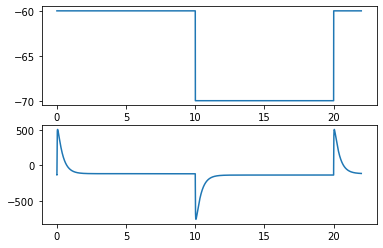

In [35]:


import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(d.time(), d['amp.Vc'])
ax = fig.add_subplot(2, 1, 2)
ax.plot(d.time(), d['amp.I_obs'])
plt.show()

## Recap: 1st order equations

Equations of the form
\begin{align}
\dot{x} = \frac{x_\infty - x}{\tau}
\end{align}

can be solved by substituting $y = x - x_\infty$ for
\begin{align}
\frac{dy}{dt} = \frac{-y}{\tau} \quad\longrightarrow\quad
\frac{dy}{y} = \frac{-dt}{\tau} \quad\longrightarrow\quad
\ln y = e^{-t/\tau} + C
\end{align}

taking the exponential on both sides, and solving for the integration constant gives
\begin{align}
y = c e^{-t/\tau}
  = y_0 e^{-t/\tau}
  = (x_0 - x_\infty) e^{-t/\tau}
\end{align}

for
\begin{align}
x = x_\infty - (x_\infty - x_0) e^{-t/\tau}
\end{align}

### Integrating

The integral under $x$ from $0$ to $T$ is

\begin{align}
\int_0^T x &= T x_\infty - (x_\infty - x_0) \left[ -\tau e^{-t/\tau} \right]_0^T \\
           &= T x_\infty - (x_\infty - x_0) \left[ -\tau e^{-T/\tau} + \tau \right] \\
     &\approx T x_\infty - (x_\infty - x_0) \tau, \quad \text{if } T \gg \tau
\end{align}

where $T$ doesn't need to be _that_ much greater than $\tau$. 
For $T/\tau$ we already find $e^{-20}\approx 2\cdot10^{-9}$.



### Electronics version

In a scenario with $x = I$, $\tau = RC$, and $I_\infty - I_0 = \Delta I$, the contribution of the second term is given by

\begin{align}
-\Delta I \tau = -\frac{\Delta V}{R} RC = - \Delta V C
\end{align}

